# Applying unsupervised learning methods to flow cytometry data

In [36]:
from __future__ import division
import pylab as plt
import FlowCytometryTools
from FlowCytometryTools import test_data_dir, test_data_file, FCMeasurement, FCPlate, ThresholdGate, PolyGate
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KernelDensity
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
import FlowFunctions as ff
import scipy.signal as signal
import pandas as pd 
from scipy.sparse import hstack
import numpy as np

%matplotlib inline

In [2]:
plate = FCPlate.from_dir(ID='Demo Plate', path= './20151203/CTC_FVD_Hoechst_test120315/', parser='name')
plate = plate.transform('hlog', channels=['FSC-A', 'SSC-A', 'PI (B)-A', 'Alexa Fluor 488-A', 'Pacific Blue-A'])
plate = plate.dropna()

We're interested in looking at the distribution of events for the channel that CTC is in (PI (B)-A). 

Below is the distribution of CTC for cells that were labelled with only CTC.

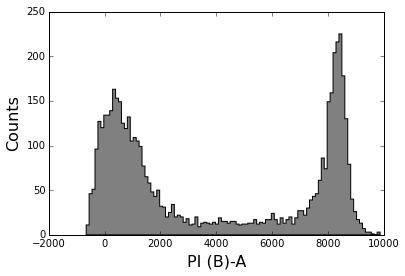

In [3]:
plate['A3'].plot('PI (B)-A', bins=100);

Let's look at the distribution of CTC for all samples. 

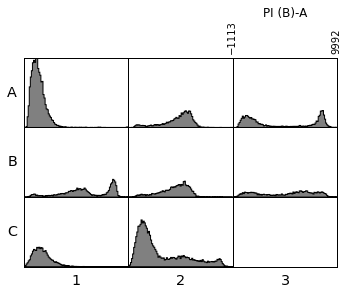

In [4]:
plate.plot('PI (B)-A', bins=100);

So we see a clear bimodal distribution in cells with just CTC (A3) and cells with Hoechst and CTC (B1). 

But we only care about events that are stained with Hoechst, so lets plot CTC (Y-axis) against Hoechst (X-axis).

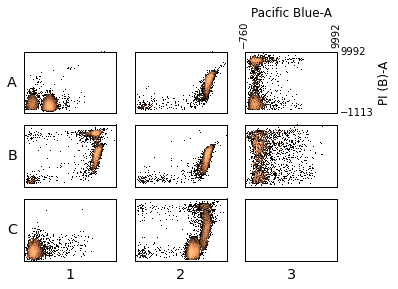

In [5]:
 plate.plot(('Pacific Blue-A', 'PI (B)-A'), bins=100, wspace=0.2, hspace=0.2);

As a reference, below is the distribution of Hoechst for all samples.

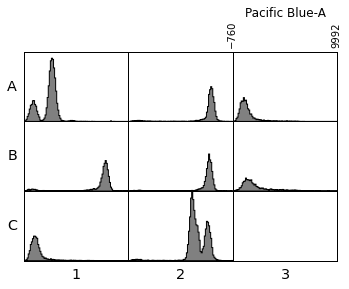

In [6]:
plate.plot('Pacific Blue-A', bins=100);

We get some nice separation for cells stained with CTC & Hoechst. Looking at the cell with all the dyes (C2), we can see that there is separation even though the two clusters are centered on different points of the X-axis.  

~~Now we need to remove the background noise so that we can cluster events into active and dormant portions. ~~

~~Let's start with defining what a DNA-stained cell is. Because of the bimodal distribution for Hoechst, which we don't expect, we'll gate the data based on samples with Hoescht that show a unimodal distribution (A3, B3, C1).~~

~~**To do:** Find a method for establishing a cutoff for a 1-D, right-tailed distribution.~~

~~That the sample with all the dyes has an unexpected bimodal distribution makes clustering difficult. What we can do is look at the sample with just CTC and cluster it. We can then use that analysis to define the cutoff for active and dormant cells in the sample with all the dyes. ~~

~~To cluster the CTC sample, we'll do the following:~~

    ~~- Apply Kernel Density Estimation (KDE) to the CTC dimension of the sample~~
    
    - Perform cross-validation to optimize the bandwidth of the KDE
    
    - Estimate the number of peaks in the distribution
    
    - Set the k in k-means clustering to the number of peaks
    
    - Apply that boundry to the dataset with all 

But we see a weird distribution of CTC for samples A1 and C2. That's because those two samples have beads. We need to gate the beads from the data for downstream analysis and to estimate the number of cells in the sample.


**To do: find statistic to estimate cutoff for beads**

The sample has 10002 beads.


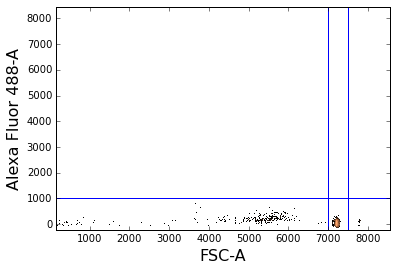

In [11]:
bead_gate_below_Y = ThresholdGate(1000.0, 'Alexa Fluor 488-A', region='below')
bead_gate_above_X = ThresholdGate(7000.0, 'FSC-A', region='above')
bead_gate_below_X = ThresholdGate(7500.0, 'FSC-A', region='below')
intersection_gate_beads = bead_gate_below_Y & bead_gate_above_X & bead_gate_below_X
plate['A1'].plot(('FSC-A', 'Alexa Fluor 488-A'), gates = [intersection_gate_beads], bins=1000);
gated_sample_beads_A1= plate['A1'].gate(intersection_gate_beads)
beads_A1 = gated_sample_beads_A1.get_data().shape[0]
print "The sample has " + str(beads_A1) + " beads."

By using the gated portion of the data, we have 10,002 beads in the sample.

We can apply this gate to the sample with all the dyes.

In [12]:
gated_sample_beads_C2 = plate['C2'].gate(intersection_gate_beads)
beads_C2 = gated_sample_beads_C2.get_data().shape[0]
print "The sample has " + str(beads_C2) + " beads."

The sample has 9990 beads.


Now we remove the beads from the data, so we can proceed with downstream analysis. 

Now we plot Hoechst vs. CTC for our data with the beads removed.

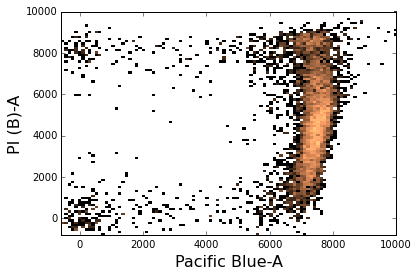

In [13]:
inverted_gate_beads = ~intersection_gate_beads
gated_sample_no_beads = plate['C2'].gate(inverted_gate_beads)
no_beads_C2 = gated_sample_no_beads.get_data().shape[0]
gated_sample_no_beads.plot(('Pacific Blue-A', 'PI (B)-A'), bins=100);

We can see that on the Y-axis we've lost our bimodality. However, we can gate our sample that only has CTC and use apply that threshold to other datasets.

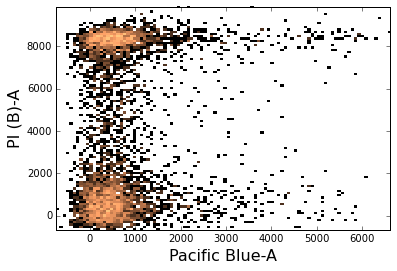

In [10]:
plate['A3'].plot(('Pacific Blue-A', 'PI (B)-A'), bins=100);

Looks like there's a bimodal distribution for CTC and a unimodal distribution for Hoechst. Looking at just CTC, we can apply Kernel Density Estimation (KDE) to estimate the Probability Density Function. 

In [16]:
A3_CTC = plate['A3'].data[['PI (B)-A']].values
A3_CTC_kde = ff.CV_KDE(A3_CTC)

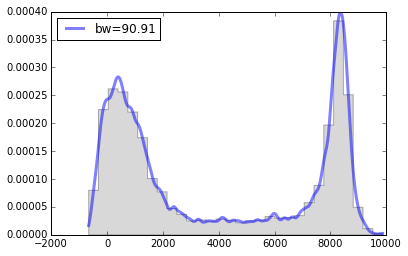

In [17]:
fig, ax = plt.subplots()
ax.plot(A3_CTC_kde[0], A3_CTC_kde[1], linewidth=3, alpha=0.5, label='bw=%.2f' % A3_CTC_kde[2])
ax.hist(A3_CTC1, 30, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
ax.legend(loc='upper left')

I'm having trouble with my peak finding function, so let's say this looks like two peaks and we'll set k = 2.

However, we can use an alternate method to find an appropriate number of clusters, the **Elbow Plot**. As k increases, the sum of the distances of samples to the closest cluster center will decrease (which is referred to as distortion). The idea behind the elbow method is that the optimal number of clusters is where there is the greatest decrease in distortion (i.e. the most negative slope between incremental values of k). Let's see it applied to this dataset.

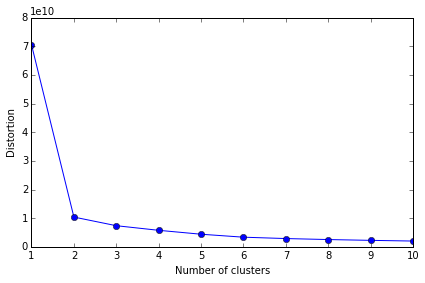

In [55]:
ff.elbow_plot(plate['A3'].data[['Pacific Blue-A', 'PI (B)-A']].values)

So it looks like there's the sharpest decrease in distortion with a K of 2.

Let's cluster the data and visualize it.  

**Note:** we're setting init in the Kmeans function to 'k-means_++', this avoids 'bad' clustering attempts of the algorithm by placing the centroids far away from each other. 

/Users/WRShoemaker/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


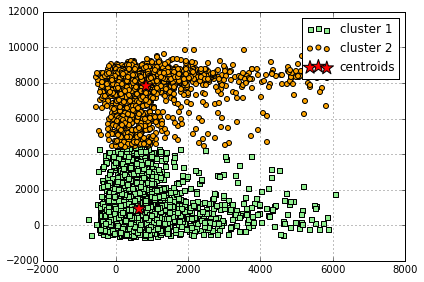

In [3]:
X = plate['A3'].data[['Pacific Blue-A', 'PI (B)-A']].values

km = KMeans(n_clusters=2, init='k-means++', n_init=10, 
            max_iter=300, tol=1e-04, random_state=0)

y_km = km.fit_predict(X)

plt.scatter(X[y_km==0,0], X[y_km==0,1], s=25, 
            c='lightgreen', marker='s', label='cluster 1')
plt.scatter(X[y_km==1,0], X[y_km==1,1], s=25, 
            c='orange', marker='o', label='cluster 2')

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], 
            s=200, marker='*', c='red', label='centroids')

plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/centroids.png', dpi=300)
plt.show()

Pretty good clustering. This data looks like it can be separated. We can add the cluster membership to the data matrice and perform logistic regression.

In [4]:
df_processed = plate['A3'].data.copy()
df_processed['Cluster Class'] = pd.Series(km.labels_, index=df_processed.index)

In [8]:
X = df_processed[['Pacific Blue-A','PI (B)-A']]
y = df_processed[['Cluster Class']]

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.vstack((y_train, y_test))
y_combined = y_combined.transpose()

In [9]:
model2 = LogisticRegression()
model2.fit(X_train_std, y_train)
predicted = model2.predict(X_test_std)
probs = model2.predict_proba(X_test_std)
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)
#print probs
print model2.score(X, y)
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])
#scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=3)
#print scores
#print scores.mean()


[[860   0]
 [  0 682]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       860
          1       1.00      1.00      1.00       682

avg / total       1.00      1.00      1.00      1542

0.535214007782
1.0
1.0


/Users/WRShoemaker/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


So we expect cluster 1 to be dormant and clusr 2 to be active. So 53% of the cells are dormant. 47% of the cells are active.

We calculate the number of cells using the following formula.

$$\frac{C_{counted}}{B_{counted}} * \frac{B_{sample}}{V_{sample}} = cells/\mu L $$

Where $C_{counted}$ is the number of cells in the data, $B_{counted}$ is the number of beads in the data, $B_{sample}$ is the estimated number of cells in the sample (using the dilution level) and $V_{sample}$ is the volume of the sample.

In [56]:
dormant_freq = model2.score(X, y)
active_freq = 1 - model2.score(X, y)
gated_sample_C2_count = gated_sample_no_beads.apply(ff.count_events)
cell_count = (gated_sample_C2_count / beads_C2) * (10000 / 1000)  * 1000 * 1000
active_count = cell_count * active_freq
dormant_count = cell_count * dormant_freq
print "Active count: " + str(int(round(active_count)))
print "Dormant count: " + str(int(round(dormant_count)))

Active count: 3151147
Dormant count: 3628633
